# Machine Learning at CoDaS-HEP 2024, Lesson 4: Survey of Architectures

In lesson 1, I introduced neural networks and the universal function approximation theorem. A single hidden layer implements _adaptive_ basis functions, more flexible than classic Taylor and Fourier series.

In lesson 2, we talked about issues involed in any fitting procedure, whether multilayered or not (i.e. a pure linear fit).

Lesson 3 was an open-ended project to build your own neural network.

In lesson 4, we will consider a variety of neural network "architectures": ways of building networks to improve learning for different types of problems.

<br><br><br><br><br>

## Why should learning be "deep"?

**Deep learning:** a neural network with 3 or more layers (which is common nowadays).

<img src="../img/rise-of-deep-learning.svg" width="800">

* 2006‒2007: problems that _prevented_ the training of deep learning were solved.
* 2012: AlexNet, a GPU-enabled 8 layer network (with ReLU), won the ImageNet competition.
* 2015: ResNet, a GPU-enabled 152+ layer network (with skip-connections), won the ImageNet competition.

By 2015, it was clear that networks with many layers have more potential than one big hidden layer.

<br><br><br><br><br>

Why does it work?

One big hidden layer can approximate any shape, by optimizing adaptive basis functions, but

> Shallow networks are very good at memorization, but not so good at generalization.

That is, they have a tendency to overfit.

Why are multiple layers better?

<br><br><br><br><br>

Adaptive basis function:

$$ \psi(x; a, b) = \left\{\begin{array}{c l}
a + b x & \mbox{if } x > -a/b \\
0 & \mbox{otherwise} \\
\end{array}\right. $$

Function approximation with one hidden layer:

$$ f_j(x) = \sum_i^{N_1} \psi(x; a_{ij}, b_{ij}) c_{ij} $$

Function approximation with two hidden layers:

$$ f_k(x) = \sum_j^{N_2} \psi\left(x; \left[
\sum_i^{N_1} \psi(x; a_{i1}, b_{i1}) c_{i1}
\right], \left[
\sum_i^{N_1} \psi(x; a_{i2}, b_{i2}) c_{i2}
\right]\right) \left[
\sum_i^{N_1} \psi(x; a_{i3}, b_{i3}) c_{i3}
\right] $$

And so on: adaptively adaptive basis functions, then adaptively adaptively adaptive basis functions...

<br><br><br><br><br>

* Another neuron in a single layer adds one more wiggle to the fit function.
* Another layer effectively folds the space under the next set of wiggly functions. Instead of fitting individual wiggles, they find symmetries in the data that (probably) correspond to an underlying relationship, rather than noise.

Consider this horseshoe-shaped decision boundary: with two well-chosen folds along the symmetries, it reduces to a simpler curve to fit. Instead of 4 ad-hoc wiggles, it's 2 folds and 1 wiggle.

<img src="../img/deep-learning-by-space-folding.svg" width="800">

Montúfar, Pascanu, Cho, & Bengio, [_On the Number of Linear Regions of Deep Neural Networks_](https://arxiv.org/abs/1402.1869) (2014).

<br><br><br><br><br>

Roy Keyes's fantastic demo ([with code](https://gist.github.com/jpivarski/f99371614ecaa48ace90a6025d430247)):

<img src="../img/network-layer-space-folding.png" width="800">

A uniform grid on the feature space (left; grid not shown) projected through the first layer's transformation shows what the underlying space looks like (right; grid is gray) before the second layer makes a linear decision boundary.

<br><br><br><br><br>

This is our first architecture:

<img src="../img/artificial-neural-network-layers-2.svg" width="700">

Neurons in a layer add wiggles to the fitted function; layers add reflections and symmetries that are (probably) real structure.

<br><br><br><br><br>

## Autoencoders

This is our second architecture, and **autoencoder**:

<img src="../img/artificial-neural-network-layers-autoencoder.svg" width="700">

It's network structure is like the first except that the number of neurons shrink to a "pinch point" and then return to the original size.

The training is different: instead of trying to fit to known targets, the output attempts to reproduce the input.

This is **unsupervised learning**. Unlike **supervised learning**, in which we want the model to produce an expected answer, in this case, we want to see what the model comes up with on its own.

Before talking about it in detail, let's run an autoencoder on the same jet data that you classified with supervised learning.

In [134]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import sklearn.datasets
import torch
from torch import nn
from torch import optim

In [27]:
hls4ml_lhc_jets_hlf = sklearn.datasets.fetch_openml("hls4ml_lhc_jets_hlf")

features_unnormalized = torch.tensor(hls4ml_lhc_jets_hlf["data"].values).float()

features = (features_unnormalized - features_unnormalized.mean(axis=0)) / features_unnormalized.std(axis=0)

In [166]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.shrinking = nn.Sequential(
            nn.Linear(16, 12),
            nn.Sigmoid(),
            nn.Linear(12, 8),
            nn.Sigmoid(),
            nn.Linear(8, 4),
            nn.Sigmoid(),
            nn.Linear(4, 2),
            nn.Sigmoid(),
        )
        self.growing = nn.Sequential(
            nn.Linear(2, 4),
            nn.Sigmoid(),
            nn.Linear(4, 8),
            nn.Sigmoid(),
            nn.Linear(8, 12),
            nn.Sigmoid(),
            nn.Linear(12, 16),
        )

    def forward(self, features):
        return self.growing(self.shrinking(features))

model = Autoencoder()

In [167]:
NUM_EPOCHS = 100
BATCH_SIZE = 1000

loss_function = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.03)

loss_vs_epoch = []
for epoch in range(NUM_EPOCHS):
    total_loss = 0

    for start_batch in range(0, len(features), BATCH_SIZE):
        stop_batch = start_batch + BATCH_SIZE

        optimizer.zero_grad()
    
        predictions = model(features[start_batch:stop_batch])
        loss = loss_function(predictions, features[start_batch:stop_batch])
        total_loss += loss.item()
    
        loss.backward()
        optimizer.step()

    loss_vs_epoch.append(total_loss)
    print(f"{epoch = } {total_loss = }")

epoch = 0 total_loss = 325.29809561371803
epoch = 1 total_loss = 191.3061871677637
epoch = 2 total_loss = 177.32360683381557
epoch = 3 total_loss = 169.3583533167839
epoch = 4 total_loss = 167.92090420424938
epoch = 5 total_loss = 165.48566557466984
epoch = 6 total_loss = 165.52079701423645
epoch = 7 total_loss = 161.4607362896204
epoch = 8 total_loss = 158.01348599791527
epoch = 9 total_loss = 155.35110571980476
epoch = 10 total_loss = 155.88811817765236
epoch = 11 total_loss = 151.56064367294312
epoch = 12 total_loss = 151.85434675216675
epoch = 13 total_loss = 151.44032472372055
epoch = 14 total_loss = 150.34826923906803
epoch = 15 total_loss = 150.65497985482216
epoch = 16 total_loss = 149.61602246761322
epoch = 17 total_loss = 149.13880340754986
epoch = 18 total_loss = 151.93106169998646
epoch = 19 total_loss = 156.43760101497173
epoch = 20 total_loss = 151.8343911021948
epoch = 21 total_loss = 148.96825237572193
epoch = 22 total_loss = 148.59056662023067
epoch = 23 total_loss = 1

<br><br><br><br><br>

To reproduce the 16-dimensional input data using only 2 dimensions in the middle, the model has to encode it with as little redundancy as possible.

We are asking the model to perform lossy compression—to _approximate_ the 16-dimensional data in 2 dimensions.

The data in 2 dimensional space looks very different from how it looks in the original 16 dimensions, but the biggest distinctions in one space are big distinctions in the other. This is an **embedding space** for the data.

Aside: in text processing networks, embedding spaces for sentences replace exact words with concepts, where synonyms are close to each other and multiple meanings are contextualized.

<img src="../img/neural-network-for-language.svg" width="300">

<br><br><br><br><br>

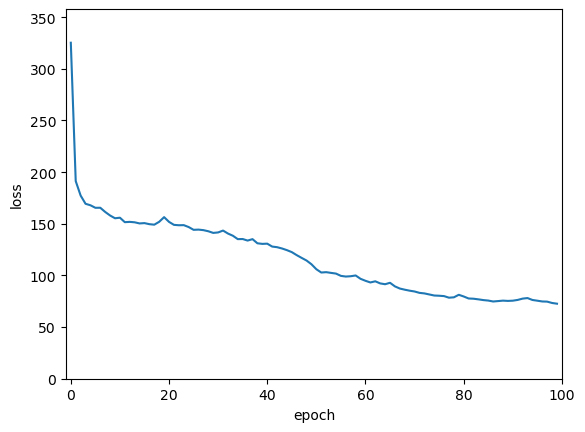

In [194]:
fig, ax = plt.subplots()

ax.plot(range(len(loss_vs_epoch)), loss_vs_epoch)
ax.set_xlim(-1, len(loss_vs_epoch))
ax.set_ylim(0, 1.1*max(loss_vs_epoch))
ax.set_xlabel("epoch")
ax.set_ylabel("loss")

None

<br><br><br><br><br>

What does the data look like in the 2 dimensional space at the "pinch point" of the network?

In [198]:
embedded = model.shrinking(features).detach().numpy()

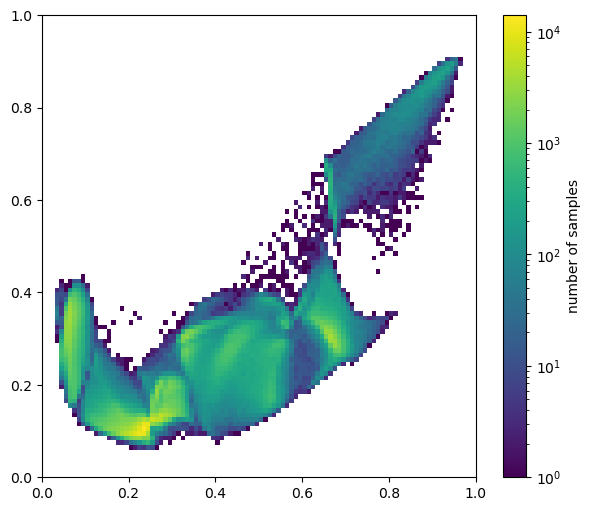

In [205]:
fig, ax = plt.subplots(figsize=(7, 6))

p = ax.hist2d(embedded[:, 0], embedded[:, 1], bins=(100, 100), range=((0, 1), (0, 1)), norm=mpl.colors.LogNorm())
fig.colorbar(p[-1], ax=ax, label="number of samples")
ax.axis([0, 1, 0, 1])

None

<br><br><br><br><br>

The model found some clumps; some clusters of different-looking jets.

Do these correspond to the `'g'`, `'q'`, `'t'`, `'w'`, `'z'` categories, the physically different hadronization mechanisms?

In [168]:
targets = torch.tensor(hls4ml_lhc_jets_hlf["target"].cat.codes.values).long()

In [169]:
hls4ml_lhc_jets_hlf["target"].cat.categories

Index(['g', 'q', 't', 'w', 'z'], dtype='object')

In [170]:
embedded_g = model.shrinking(features[targets == 0]).detach().numpy()
embedded_q = model.shrinking(features[targets == 1]).detach().numpy()
embedded_t = model.shrinking(features[targets == 2]).detach().numpy()
embedded_w = model.shrinking(features[targets == 3]).detach().numpy()
embedded_z = model.shrinking(features[targets == 4]).detach().numpy()

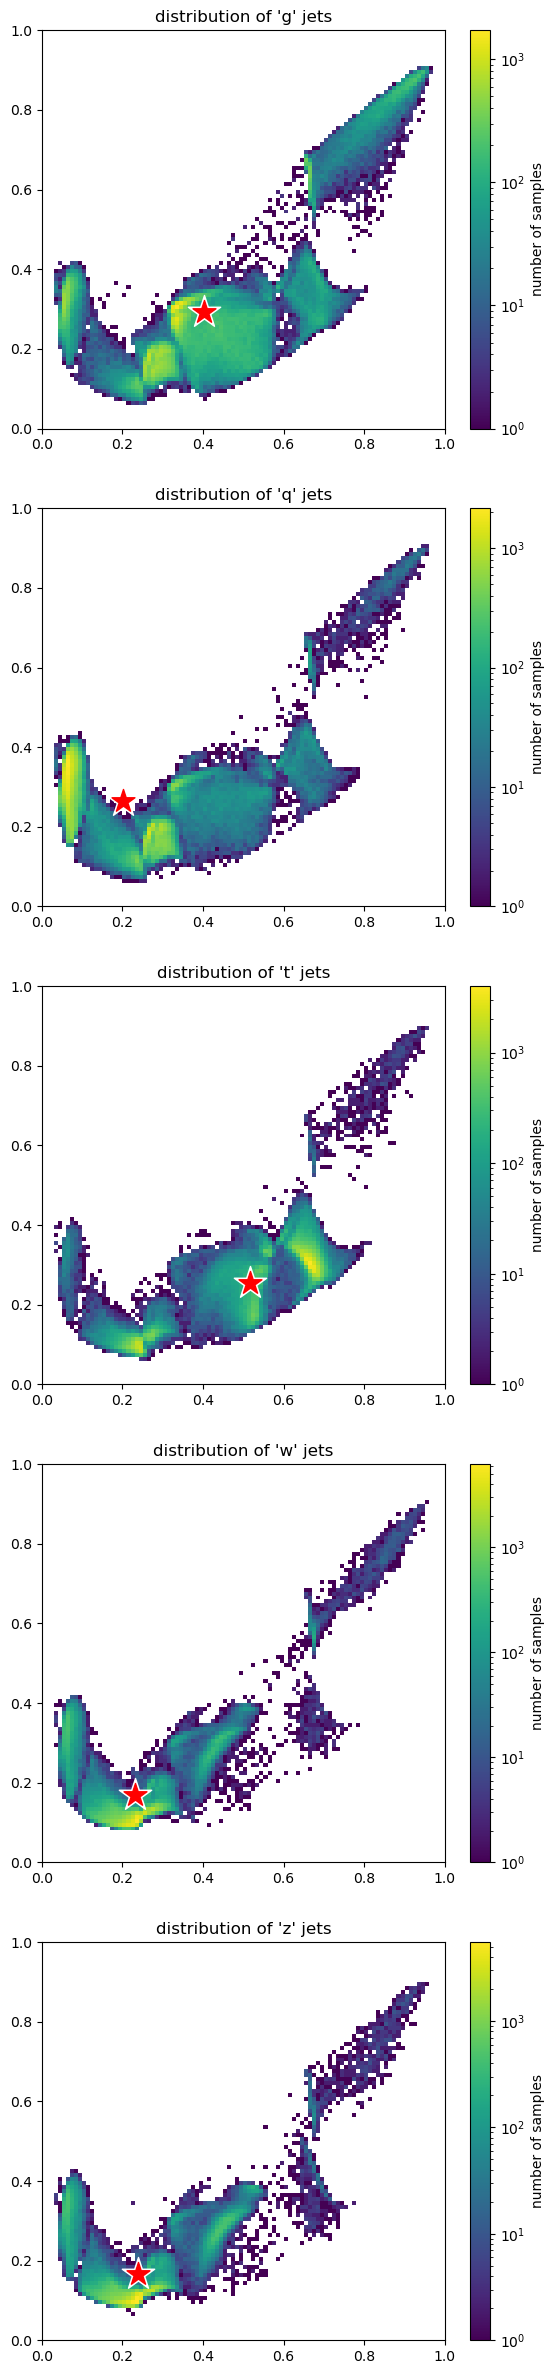

In [196]:
fig, axs = plt.subplots(5, 1, figsize=(6.5, 30))

ps = []
for (ax, (name, embedded)) in zip(axs, [
    ["g", embedded_g], ["q", embedded_q], ["t", embedded_t], ["w", embedded_w], ["z", embedded_z]
]):
    ps.append(ax.hist2d(embedded[:, 0], embedded[:, 1], bins=(100, 100), range=((0, 1), (0, 1)), norm=mpl.colors.LogNorm()))
    fig.colorbar(ps[-1][-1], ax=ax, label="number of samples")
    ax.scatter([embedded[:, 0].mean()], [embedded[:, 1].mean()], marker="*", s=600, color="white")
    ax.scatter([embedded[:, 0].mean()], [embedded[:, 1].mean()], marker="*", s=300, color="red")
    ax.set_title(f"distribution of '{name}' jets")
    ax.axis([0, 1, 0, 1])

None

Not quite. `'g'`, `'q'`, `'t'` populate different clusters from each other, although the model split them up with more granularity.

The `'w'`, `'z'` are different from the quark-gluon jets, but not different from each other.

It would be interesting to map these clusters back to the original 16-dimensional jets, to understand what these phenominological clusters mean, but not now.

Moving on!

<br><br><br><br><br>

## Variational autoencoder

## Convolutional neural network